In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import accuracy_score

# READ FROM DATABASE

In [2]:
import psycopg2
import pickle
import copy

In [3]:
# jdbc:postgresql://pg-graduate-delt.postgres.database.azure.com:5432/{your_database}?user=snartimaal&password={your_password}&sslmode=require
with psycopg2.connect(
    database='pgsql-graduate-gruppe3',
    user='snartimaal',
    password='#st44p44nu',
    host='pg-graduate-delt.postgres.database.azure.com'
) as conn:
    cur = conn.cursor()

### Mattilsynet 

In [4]:
try:
    cur = conn.cursor()
    df_sql_mat = pd.read_sql_query("SELECT cs.overordnetenhet, m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN company_subunit cs ON oj.orgnumber = cs.organisasjonsnummer;", 
                                  conn)
except:
    conn.rollback()
    cur.close()

C:\Users\STM\AppData\Local\Temp\ipykernel_22136\2236806454.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_mat = pd.read_sql_query("SELECT cs.overordnetenhet, m.orgnummer, m.postnr, m.total_karakter, m.dato, m.tilsynsbesoektype, cs.antallansatte, cs.naeringskode1_kode \


In [5]:
df_sql_mat

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode
0,915708951,915937144,368,2,21112022,1,69.0,56.101
1,915647774,974999439,366,0,23012020,0,17.0,47.241
2,915865488,915893848,369,0,14092017,1,25.0,56.101
3,919146133,919228660,178,0,21082018,1,7.0,56.101
4,931531018,912240770,1081,0,26112018,1,80.0,55.101
...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101
5837,994668749,996480550,190,1,01092022,0,4.0,56.102
5838,913473302,913536835,194,0,09092022,0,4.0,56.101
5839,929609220,929774671,179,1,12122022,0,21.0,56.101


# Ledere
Styremedlemer, Styreleder, Nestleder, Vara etc.

In [8]:
list_of_df = [  "df_styremedlemjunction_table",
                "df_varamedlemjunction_table",
                "df_styrets_lederjunction_table",
                "df_nestlederjunction_table",
                "df_kontaktpersonjunction_table",
                "df_innehaverjunction_table"]
daglig_leder = "df_daglig_lederjunction_table"
people = "df_people_gender"

In [9]:
def get_leader_info(name):
    path_ = "../Data/Extracted/"
    suffix = ".obj"

    with open(path_+name+suffix, 'rb') as f:
        df = pickle.load(f)
    return df

In [10]:
df_people = get_leader_info(people)
daglig_leder = get_leader_info(daglig_leder)

In [11]:
leaders = []

for item in list_of_df:
    leaders.append(get_leader_info(item))

In [12]:
# Gets all leaders for each org number.

list_of_org_num = df_sql_mat['overordnetenhet'].tolist()
unique_leader = {}
for org_num in list_of_org_num:
    unique_leader[org_num] = []

count = 0
for org_num in list_of_org_num:
    count += 1

    for leader_role in leaders:

        for index, row in leader_role.iterrows():

            if int(row['organisasjonsnummer']) == int(org_num):
                unique_leader[org_num].append(row['person_id'])

KeyboardInterrupt: 

In [46]:
# Reduces the leaders for each org number to only unique.
only_unique_leader = {}
for key, value in unique_leader.items():
    only_unique_leader[key] = list(set(value))

In [47]:
# Count of leaders and the gender rate. 0 beeing all female and 1 beeing all male.
counted_leaders = {}
for key, value in only_unique_leader.items():
    sex = 0
    for leader in value:
        sex = sex + int(df_people.loc[df_people['person_id'] == leader, 'sex'])
        
    if len(value) == 0:
        counted_leaders[key] = [len(value), np.nan]
    else:
        counted_leaders[key] = [len(value), sex/len(value)]

### Daglig leder

In [48]:
# Gets all aglig leaders for each org number.

list_of_org_num = df_sql_mat['overordnetenhet'].tolist()
unique_leader = {}
for org_num in list_of_org_num:
    unique_leader[org_num] = []

for org_num in list_of_org_num:

    for index, row in daglig_leder.iterrows():

        if int(row['organisasjonsnummer']) == int(org_num):
            unique_leader[org_num].append(row['person_id'])

KeyboardInterrupt: 

In [172]:
# Reduces the leaders for each org number to only unique.
only_unique_leader = {}
for key, value in unique_leader.items():
    only_unique_leader[key] = list(set(value))

In [173]:
# Count of leaders and the gender rate. 0 beeing all female and 1 beeing all male.
counted_daglig_leaders = {}
for key, value in only_unique_leader.items():
    sex = 0
    for leader in value:
        sex = sex + int(df_people.loc[df_people['person_id'] == leader, 'sex'])
        
    if len(value) == 0:
        counted_daglig_leaders[key] = [len(value), np.nan]
    else:
        counted_daglig_leaders[key] = [len(value), sex/len(value)]

In [7]:
print(len(counted_daglig_leaders))
print(len(counted_leaders))

NameError: name 'counted_daglig_leaders' is not defined

In [99]:
with open('leader_and_direct_leader_data.obj', 'rb') as f:
    leader_and_direct_leader_data = pickle.load(f)

### Styremedlemmer

In [100]:
try:
    cur = conn.cursor()
    df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \
                                  FROM mattilsynet m \
                                  JOIN orgnumber_junction oj ON m.orgnummer = oj.orgnumber \
                                  JOIN styremedlem_junction sj ON oj.orgnumber = sj.organisasjonsnummer \
                                  JOIN people p ON sj.person_id = p.person_id ;", 
                                  conn)
except:
    conn.rollback()
    cur.close()


C:\Users\STM\AppData\Local\Temp\ipykernel_22136\2516288090.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_styre = pd.read_sql_query("SELECT m.orgnummer, p.person_id, oj.org_name \


### Google Review

In [101]:
try:
    cur = conn.cursor()
    df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \
                                 FROM google_review gr;", 
                                 conn)
except:
    conn.rollback()
    cur.close()


C:\Users\STM\AppData\Local\Temp\ipykernel_22136\2155275846.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_reviews = pd.read_sql("SELECT gr.organisasjonsnummer AS orgnummer, gr.individual_rating \


In [102]:
avg_df = df_sql_reviews.groupby('orgnummer').mean()
min_max_df = (df_sql_reviews.groupby('orgnummer').max()) - (df_sql_reviews.groupby('orgnummer').min())
min_max_df['dif_rating'] = min_max_df.pop('individual_rating')
avg_df['avg_rating'] = avg_df.pop('individual_rating')

In [103]:
df_sql_mat

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode
0,915708951,915937144,368,2,21112022,1,69.0,56.101
1,915647774,974999439,366,0,23012020,0,17.0,47.241
2,915865488,915893848,369,0,14092017,1,25.0,56.101
3,919146133,919228660,178,0,21082018,1,7.0,56.101
4,931531018,912240770,1081,0,26112018,1,80.0,55.101
...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101
5837,994668749,996480550,190,1,01092022,0,4.0,56.102
5838,913473302,913536835,194,0,09092022,0,4.0,56.101
5839,929609220,929774671,179,1,12122022,0,21.0,56.101


In [104]:
df_test = pd.merge(df_sql_mat, avg_df, how='left', on='orgnummer')
df_test = pd.merge(df_test, min_max_df, how='left', on='orgnummer')

In [105]:
df_test

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.4,2.0
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.0,2.0
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.6,1.0
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.8,1.0
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.2,3.0
...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,NaN,NaN
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.4,4.0
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.0,0.0
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.6,4.0


In [106]:
df_test.isnull().sum()

overordnetenhet         0
orgnummer               0
postnr                  0
total_karakter          0
dato                    0
tilsynsbesoektype       0
antallansatte           0
naeringskode1_kode      0
avg_rating            658
dif_rating            658
dtype: int64

In [107]:
df_copy = df_test.copy()

In [108]:
mean_avg = df_copy['avg_rating'].mean()
mean_dif = df_copy['dif_rating'].mean()
df_copy['avg_rating'] = df_copy['avg_rating'].fillna(value=mean_avg)
df_copy['dif_rating'] = df_copy['dif_rating'].fillna(value=mean_dif)

#### Adding cordinate location.

In [109]:
try:
    cur = conn.cursor()
    df_cordinates = pd.read_sql_query(""" 
            SELECT m.orgnummer, a.latitude, a.longitude
            FROM address a
            JOIN mattilsynet m on a.name = m.adresse;
            """
                            ,conn)
except:
    conn.rollback()
    cur.close()

C:\Users\STM\AppData\Local\Temp\ipykernel_22136\3758981977.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cordinates = pd.read_sql_query("""


In [110]:
df_cordinates.columns

Index(['orgnummer', 'latitude', 'longitude'], dtype='object')

In [111]:
df_copy.columns

Index(['overordnetenhet', 'orgnummer', 'postnr', 'total_karakter', 'dato',
       'tilsynsbesoektype', 'antallansatte', 'naeringskode1_kode',
       'avg_rating', 'dif_rating'],
      dtype='object')

In [112]:
df_copy

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000
...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000


In [113]:
df_cordinates = df_cordinates.drop_duplicates(subset=['orgnummer'])

In [114]:
df_cordinates

,orgnummer,latitude,longitude
0,915893848,59.930309,10.715419
2,919228660,59.922427,10.751924
19,912240770,59.930122,10.868260
20,917686149,59.936102,10.765475
23,873357312,59.977237,10.655501
...,...,...,...
4995,921905750,59.927632,10.796924
5153,925779318,59.901814,10.741166
5238,925872407,59.915589,10.755933
5248,927372371,59.914255,10.748027


In [115]:
# Merging the df's
df_copy = df_copy.merge(df_cordinates, how='left', on='orgnummer')

In [116]:
df_copy

,overordnetenhet,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude
0,915708951,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000,NaN,NaN
1,915647774,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000,NaN,NaN
2,915865488,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000,59.930309,10.715419
3,919146133,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000,59.922427,10.751924
4,931531018,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000,59.930122,10.868260
...,...,...,...,...,...,...,...,...,...,...,...,...
5836,925417165,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158,59.902836,10.753338
5837,994668749,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000,59.912518,10.765009
5838,913473302,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000,NaN,NaN
5839,929609220,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000,59.914400,10.747041


In [117]:
df_copy.columns

Index(['overordnetenhet', 'orgnummer', 'postnr', 'total_karakter', 'dato',
       'tilsynsbesoektype', 'antallansatte', 'naeringskode1_kode',
       'avg_rating', 'dif_rating', 'latitude', 'longitude'],
      dtype='object')

#### Adding in the leader and direct leader data.

In [118]:
df_copy['direct_leader'] = np.nan
df_copy['direct_leader_sex'] = np.nan
df_copy['leaders'] = np.nan
df_copy['leaders_sex'] = np.nan

In [119]:
def add_data_to_df(o_org, gender = False, direct = True):
    index = 0
    if gender == False:
        index = 0
    else:
        index = 1
    
    if direct == True:
        data = leader_and_direct_leader_data[0]
        #data = counted_daglig_leaders
    else:
        data = leader_and_direct_leader_data[1]
        #data = counted_leaders

    return data[o_org][index]

In [120]:
df_copy['direct_leader'] = df_copy['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = False, direct = True))
df_copy['direct_leader_sex'] = df_copy['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = True, direct = True))
df_copy['leaders'] = df_copy['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = False, direct = False))
df_copy['leaders_sex'] = df_copy['overordnetenhet'].map(lambda x: add_data_to_df(x, gender = True, direct = False))

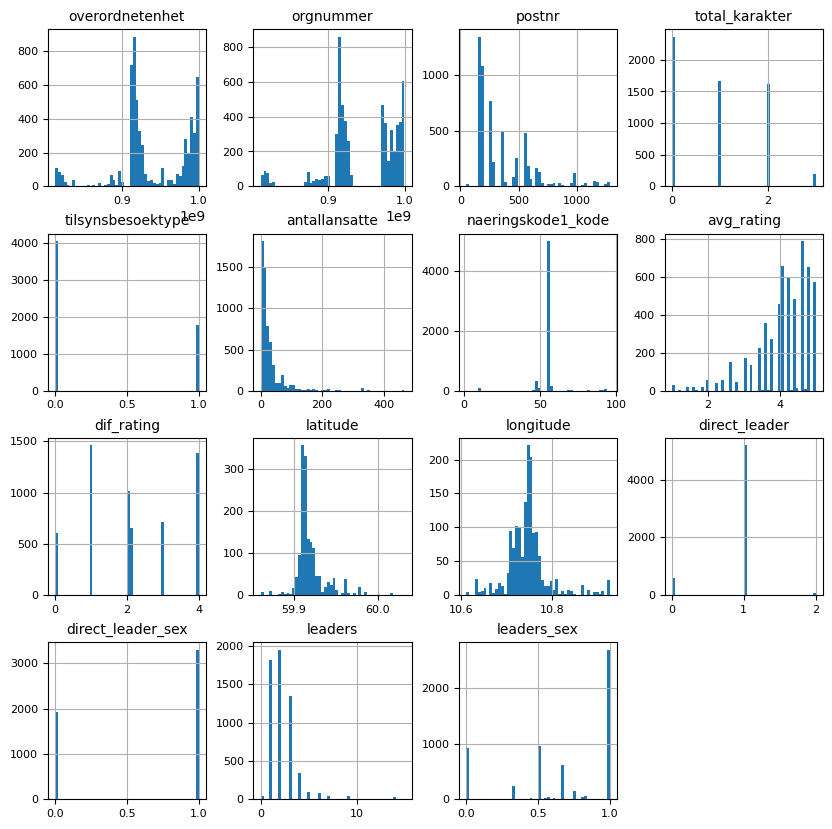

In [121]:
fig = df_copy.hist(figsize=[10,10], bins=50, xlabelsize=8, ylabelsize=8)
[x.title.set_size(10) for x in fig.ravel()];
plt.show()

# DATA PREP

In [122]:
# Endre dato til kun år ? De 4 siste sifrene 
dato = df_copy['dato']
year_list = []

for i in dato.values:
    year_list.append(int(i[-4:]))

df_copy['year'] = year_list

In [123]:
del df_copy['overordnetenhet']
df_copy

,orgnummer,postnr,total_karakter,dato,tilsynsbesoektype,antallansatte,naeringskode1_kode,avg_rating,dif_rating,latitude,longitude,direct_leader,direct_leader_sex,leaders,leaders_sex,year
0,915937144,368,2,21112022,1,69.0,56.101,4.400000,2.000000,NaN,NaN,1,1.0,3,1.000000,2022
1,974999439,366,0,23012020,0,17.0,47.241,4.000000,2.000000,NaN,NaN,1,1.0,3,1.000000,2020
2,915893848,369,0,14092017,1,25.0,56.101,4.600000,1.000000,59.930309,10.715419,1,0.0,5,0.600000,2017
3,919228660,178,0,21082018,1,7.0,56.101,4.800000,1.000000,59.922427,10.751924,0,NaN,2,0.500000,2018
4,912240770,1081,0,26112018,1,80.0,55.101,3.200000,3.000000,59.930122,10.868260,1,1.0,9,0.555556,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5836,915465870,194,0,19012023,1,34.0,56.101,4.096913,2.154158,59.902836,10.753338,1,1.0,1,1.000000,2023
5837,996480550,190,1,01092022,0,4.0,56.102,2.400000,4.000000,59.912518,10.765009,1,0.0,1,1.000000,2022
5838,913536835,194,0,09092022,0,4.0,56.101,5.000000,0.000000,NaN,NaN,1,1.0,2,0.500000,2022
5839,929774671,179,1,12122022,0,21.0,56.101,2.600000,4.000000,59.914400,10.747041,1,1.0,2,1.000000,2022


In [124]:
# Adding monthly data
month = df_copy['dato']
month_list = []

for i in dato.values:
    month_list.append(int(i[2:-4:]))

df_copy['month'] = month_list

In [125]:
df_unscaled = copy.deepcopy(df_copy)

In [126]:
df_copy = df_unscaled

In [127]:
df_copy.columns

Index(['orgnummer', 'postnr', 'total_karakter', 'dato', 'tilsynsbesoektype',
       'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
       'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
       'leaders', 'leaders_sex', 'year', 'month'],
      dtype='object')

In [128]:
df_copy.isnull().sum()

orgnummer                0
postnr                   0
total_karakter           0
dato                     0
tilsynsbesoektype        0
antallansatte            0
naeringskode1_kode       0
avg_rating               0
dif_rating               0
latitude              4288
longitude             4288
direct_leader            0
direct_leader_sex      596
leaders                  0
leaders_sex             46
year                     0
month                    0
dtype: int64

In [129]:
df_copy['direct_leader_sex'] = df_copy['direct_leader_sex'].fillna(value=-1)
df_copy['leaders_sex'] = df_copy['leaders_sex'].fillna(value=-1)

In [130]:
avg_lat = df_copy['latitude'].mean()
avg_lon = df_copy['longitude'].mean()
df_copy['latitude'] = df_copy['latitude'].fillna(value=avg_lat)
df_copy['longitude'] = df_copy['longitude'].fillna(value=avg_lon)

In [131]:
df_copy.isnull().sum()

orgnummer             0
postnr                0
total_karakter        0
dato                  0
tilsynsbesoektype     0
antallansatte         0
naeringskode1_kode    0
avg_rating            0
dif_rating            0
latitude              0
longitude             0
direct_leader         0
direct_leader_sex     0
leaders               0
leaders_sex           0
year                  0
month                 0
dtype: int64

In [465]:
# Data scaling should not be importaint with xgboost

# ss_features = [ 'postnr', 'orgnummer', 'tilsynsbesoektype', 
#                 'naeringskode1_kode', 'antallansatte', 'avg_rating', 
#                 'dif_rating', 'latitude', 'longitude', 'direct_leader', 
#                 'direct_leader_sex', 'leaders', 'leaders_sex', 'year', 'month']
# ss_scaler = StandardScaler()
# ss_scaler.fit(df_test[ss_features])
# transformed_ss = ss_scaler.transform(df_test[ss_features])
# df_test[ss_features] = transformed_ss

# TRAIN TEST SPLIT

In [132]:
df_copy.columns

Index(['orgnummer', 'postnr', 'total_karakter', 'dato', 'tilsynsbesoektype',
       'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
       'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
       'leaders', 'leaders_sex', 'year', 'month'],
      dtype='object')

In [133]:
feature_list = ['orgnummer', 'postnr', 'tilsynsbesoektype',
       'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
       'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
       'leaders', 'leaders_sex', 'year', 'month']

In [ ]:
# feature_list = ['orgnummer', 'postnr', 'tilsynsbesoektype',
#        'antallansatte', 'naeringskode1_kode', 'avg_rating', 'dif_rating',
#        'latitude', 'longitude', 'direct_leader', 'direct_leader_sex',
#        'leaders', 'leaders_sex', 'year', 'month']

In [134]:
df_train = df_copy[df_copy['year'] < 2022]
df_test = df_copy[df_copy['year'] >= 2022]

In [135]:
X_train = np.c_[df_train[feature_list]]
y_train = np.c_[df_train['total_karakter']]

X_test = np.c_[df_test[feature_list]]
y_test = np.c_[df_test['total_karakter']]

In [136]:
print(f'X_train len : {len(X_train)}')
print(f'X_test len : {len(X_test)}')
print(f'y_train len : {len(y_train)}')
print(f'y_test len : {len(y_test)}')

X_train len : 4239
X_test len : 1602
y_train len : 4239
y_test len : 1602


In [137]:
print(X_train.shape, y_train.shape)

(4239, 15) (4239, 1)


# Naiv score

In [138]:
pred_naiv = np.mean(y_train)
y_pred_naiv = np.full(y_test.shape, pred_naiv)
print(f'y_pred_naiv : {len(y_pred_naiv)}') # 1169

mse_naiv = mean_squared_error(y_test, y_pred_naiv)
print(f'Naiv MSE : {np.sqrt(mse_naiv)}') # 0.9147

mae_naiv = mean_absolute_error(y_test, y_pred_naiv)
print(f'Naiv MAE : {mae_naiv}') # 0.7819

y_pred_naiv : 1602
Naiv MSE : 0.8449077795580826
Naiv MAE : 0.6735902191145239


# XGBoost Model

In [149]:
regressor = xgb.XGBRegressor(
    early_stopping_rounds = 20,
    max_depth = 2
)

regressor.fit(X_train, y_train, eval_set = [(X_test, y_test)])
importance_check = pd.DataFrame(regressor.feature_importances_.reshape(1,-1), columns = [feature_list])


[0]	validation_0-rmse:0.85791
[1]	validation_0-rmse:0.82763
[2]	validation_0-rmse:0.79827
[3]	validation_0-rmse:0.77907
[4]	validation_0-rmse:0.77382
[5]	validation_0-rmse:0.76790
[6]	validation_0-rmse:0.76394
[7]	validation_0-rmse:0.76433
[8]	validation_0-rmse:0.76207
[9]	validation_0-rmse:0.76208
[10]	validation_0-rmse:0.76149
[11]	validation_0-rmse:0.76242
[12]	validation_0-rmse:0.76070
[13]	validation_0-rmse:0.75976
[14]	validation_0-rmse:0.76007
[15]	validation_0-rmse:0.76037
[16]	validation_0-rmse:0.76041
[17]	validation_0-rmse:0.76198
[18]	validation_0-rmse:0.76075
[19]	validation_0-rmse:0.76113
[20]	validation_0-rmse:0.76081
[21]	validation_0-rmse:0.76120
[22]	validation_0-rmse:0.76168
[23]	validation_0-rmse:0.76159
[24]	validation_0-rmse:0.76223
[25]	validation_0-rmse:0.76208
[26]	validation_0-rmse:0.76162
[27]	validation_0-rmse:0.76165
[28]	validation_0-rmse:0.76223
[29]	validation_0-rmse:0.76463
[30]	validation_0-rmse:0.76426
[31]	validation_0-rmse:0.76475
[32]	validation_0-

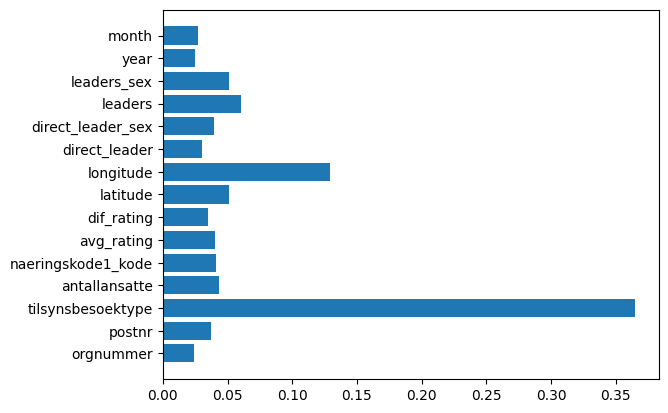

In [147]:
plt.barh(feature_list, regressor.feature_importances_)
plt.show()

# Scoring xg

In [152]:
# Train xg
r2_train_xg = regressor.score(X_train, y_train)
print(f'Train R2 XG : {r2_train_xg}') # 6f 0.3071 / m.år 0.4545

y_pred_train_xg = regressor.predict(X_train)
mse_train_xg = mean_squared_error(y_train, y_pred_train_xg)
print(f'Train MSE XG : {np.sqrt(mse_train_xg)}') # 6f 0.7480 / m.år 0.6641

mae_train_xg = mean_absolute_error(y_train, y_pred_train_xg)
print(f'Train MAE XG : {mae_train_xg}') # 6f 0.5854 / m.år 0.5156

# Test xg
r2_test_xg = regressor.score(X_test, y_test)
print(f'Test R2 XG : {round(r2_test_xg, 4)}') # 6f 0.1754 / m.år 0.2766

y_pred_test_xg = regressor.predict(X_test)
mse_test_xg = mean_squared_error(y_test, y_pred_test_xg)
print(f'Test MSE XG : {round(np.sqrt(mse_test_xg), 4)}') # 6f 0.8305 / m.år 0.7755

mae_test_xg = mean_absolute_error(y_test, y_pred_test_xg)
print(f'Test MAE XG : {round(mae_test_xg, 4)}') # 6f 0.6631 / m.år 0.6029

Train R2 XG : 0.2343836033889677
Train MSE XG : 0.8072542671292123
Train MAE XG : 0.6612195969102489
Test R2 XG : 0.1914
Test MSE XG : 0.7598
Test MAE XG : 0.5777


# Linear Regression Model

In [153]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_test, y_test)

## TRAIN

r2_train = lin_reg_model.score(X_train, y_train)
y_train_pred_linreg = lin_reg_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred_linreg)
mse_train = mean_squared_error(y_train, y_train_pred_linreg)
print(f'Train R2 : {r2_train}') # 0.1616 / 6f 0.17036 / m.år 0.1595
print(f'Train MAE : {mae_train}') # 0.6758 / 6f 0.6559 / m.år 0.6557
print(f'Train MSE : {np.sqrt(mse_train)}') # 0.8256 / 6f 0.8185 / m.år 0.8244

## TEST

r2_test = lin_reg_model.score(X_test, y_test)
y_test_pred_linreg = lin_reg_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred_linreg)
mse_test = mean_squared_error(y_test, y_test_pred_linreg)
print(f'Test R2 : {round(r2_test, 4)}') # 0.1802 / 6f 0.1664 / m.år 0.2152
print(f'Test MAE : {round(mae_test, 4)}') # 0.6662 / 6f 0.6802 / m.år 0.6399
print(f'Test MSE : {round(np.sqrt(mse_test), 4)}') # 0.8164 / 6f 0.8351 / m.år 0.8077

Train R2 : -0.1837683954761291
Train MAE : 0.7539007128214303
Train MSE : 1.003779003038028
Test R2 : 0.205
Test MAE : 0.5745
Test MSE : 0.7533


# Logistic Regression Model

Train accuracy : 0.42274121255012975
Train Precision : nan
Train Recall : nan


C:\Users\STM\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\STM\AppData\Local\Temp\ipykernel_22136\1812019580.py:20: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_train = tp_train/(tp_train+fp_train)
C:\Users\STM\AppData\Local\Temp\ipykernel_22136\1812019580.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
  recall_train = tp_train/(tp_train+fn_train)


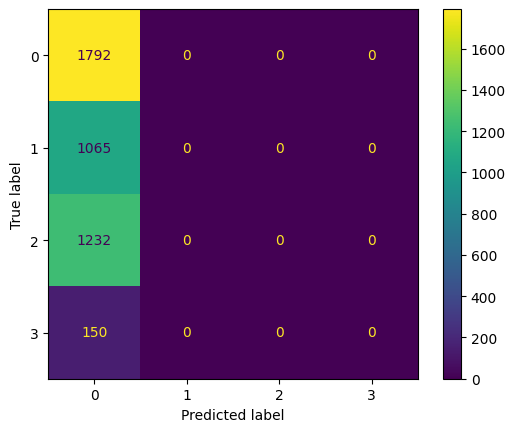

In [143]:
# y_train = y_train.reshape(-1)
log_reg_model = LogisticRegression(max_iter = 1000)
log_reg_model.fit(X_train, y_train)

y_pred_cm = log_reg_model.predict(X_train)
#y_train_pred_prod = log_reg_model.predict_proba(X_train)
#y_train_pred_prod_1 = y_train_pred_prod[:,1]
#y_train_pred = y_train_pred_prod_1 > 0.1

train_acc = accuracy_score(y_train, y_pred_cm)
print(f'Train accuracy : {train_acc}')

cm_train = confusion_matrix(y_train, y_pred_cm)

tn_train = cm_train[0,0]
fp_train = cm_train[1,1]
fn_train = cm_train[2,2]
tp_train = cm_train[3,3]

precision_train = tp_train/(tp_train+fp_train)
recall_train = tp_train/(tp_train+fn_train)
print(f'Train Precision : {precision_train}')
print(f'Train Recall : {recall_train}')

ConfusionMatrixDisplay(cm_train).plot()
plt.show()

# KNeighbors Regressor Model

In [158]:
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train, y_train)

# KNN score
# Train
R2_train_knn = model_knn.score(X_train, y_train)
y_pred_train_knn = model_knn.predict(X_train)
mae_train_knn = mean_absolute_error(y_train, y_pred_train_knn)
mse_train_knn = mean_squared_error(y_train, y_pred_train_knn)
print(f'Knn Train Score:')
print(f'R2_train : {R2_train_knn}') # 0.3681
print(f'MAE train : {mae_train_knn}') # 0.5506
print(f'MSE train : {np.sqrt(mse_train_knn)}') # 0.7171

# Test
R2_test_knn = model_knn.score(X_test, y_test)
y_test_pred_knn = model_knn.predict(X_test)
mae_test_knn = mean_absolute_error(y_test, y_test_pred_knn)
mse_test_knn = mean_squared_error(y_test, y_test_pred_knn)
print(f'Knn Test Score:')
print(f'R2_test : {R2_test_knn}') # 0.1192
print(f'MAE test : {mae_test_knn}') # 0.6579
print(f'MSE test : {np.sqrt(mse_test_knn)}') # 0.8453

Knn Train Score:
R2_train : 0.1636596991239223
MAE train : 0.7187072422741213
MSE train : 0.8437159296503426
Knn Test Score:
R2_test : -0.05211509080816068
MAE test : 0.7086142322097377
MSE test : 0.8666378560466209
